https://www.kaggle.com/datasets/kazanova/sentiment140?

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan

In [ ]:
!apt-get install openjdk-8-jdk -y


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-wrapper-java libatk-wrapper-java-jni libgail-common libgail18
  libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libpcsclite1 librsvg2-common
  libxt-dev libxtst6 libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless x11-utils
Suggested packages:
  default-jre gvfs pcscd libxt-doc openjdk-8-demo openjdk-8-source visualvm
  libnss-mdns fonts-nanum fonts-ipafont-gothic fonts-ipafont-mincho
  fonts-wqy-microhei fonts-wqy-zenhei fonts-indic mesa-utils
The following NEW packages will be installed:
  ca-certificates-java fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-wrapper-java libatk-wrapper-java-jni libgail-common libgail18
  libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libpcsclite1 librsvg2-common
  libxt-dev libxtst6 libxxf86dga1 openj

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-8-openjdk-amd64/bin"


In [ ]:
!pip install pyspark


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("training") \
    .getOrCreate()

spark


In [ ]:
# STEP 1: Upload the CSV manually into Colab
from google.colab import files
uploaded = files.upload()
# STEP 2: Verify that the file exists in /content
import os
print(os.listdir("/content"))

Saving training.csv to training.csv
['.config', 'training.csv', 'sample_data']


In [ ]:
# Install PySpark if not installed
!pip install -q pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("depressiondetectionProject").getOrCreate()

# Load the unzipped CSV without a header
df_spark = spark.read.csv("/content/training.csv", header=False, inferSchema=True)

# Assign meaningful column names
new_column_names = ["target", "ids", "date", "flag", "user", "text"]
df_spark = df_spark.toDF(*new_column_names)

# Check schema and few rows
df_spark.printSchema()
df_spark.show(5)

root
 |-- target: integer (nullable = true)
 |-- ids: long (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)

+------+----------+--------------------+--------+---------------+--------------------+
|target|       ids|                date|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+------+----------+--------------------+--------+---------------+-----------------

In [ ]:
import os
print(os.listdir("/content"))

['.config', 'training.csv', 'sample_data']


In [ ]:
print("Total Records:", df_spark.count())


Total Records: 1600000


In [ ]:
# Show sample data
df_spark.show(5)

# Count nulls in each column
df_spark.select([count(when(col(c).isNull(), c)).alias(c) for c in df_spark.columns]).show()

+------+----------+--------------------+--------+---------------+--------------------+
|target|       ids|                date|    flag|           user|                text|
+------+----------+--------------------+--------+---------------+--------------------+
|     0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|     0|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|     0|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|     0|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|     0|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
+------+----------+--------------------+--------+---------------+--------------------+
only showing top 5 rows

+------+---+----+----+----+----+
|target|ids|date|flag|user|text|
+------+---+----+----+----+----+
|     0|  0|   0|   0|   0|   0|
+------+---+----+----+----+----+



In [ ]:
# List columns
print("Columns in dataset:\n", df_spark.columns)

# Describe numerical fields
df_spark.describe().show()


Columns in dataset:
 ['target', 'ids', 'date', 'flag', 'user', 'text']
+-------+------------------+--------------------+--------------------+--------+--------------------+--------------------+
|summary|            target|                 ids|                date|    flag|                user|                text|
+-------+------------------+--------------------+--------------------+--------+--------------------+--------------------+
|  count|           1600000|             1600000|             1600000| 1600000|             1600000|             1600000|
|   mean|               2.0|1.9988175522956276E9|                NULL|    NULL| 4.325887521835714E9|                NULL|
| stddev|2.0000006250002933|1.9357607362269536E8|                NULL|    NULL|5.162733218454890...|                NULL|
|    min|                 0|          1467810369|Fri Apr 17 20:30:...|NO_QUERY|        000catnap000|                 ...|
|    max|                 4|          2329205794|Wed May 27 07:27:...|NO_QU

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving training.csv to training (1).csv


In [ ]:
import os
print(os.listdir("/content"))

['.config', 'training.csv', 'training (1).csv', 'sample_data']


In [ ]:
import time
from pyspark.sql import SparkSession
import pandas as pd

# Start Spark Session
spark = SparkSession.builder.appName("UploadTimeComparison").getOrCreate()

# ----------------------------------------
# PySpark Upload & Read Time
# ----------------------------------------
start_spark = time.time()
spark_df = spark.read.csv("training.csv", header=True, inferSchema=True)
end_spark = time.time()

spark_time = end_spark - start_spark
print(f" PySpark Load Time: {spark_time:.4f} seconds")
print(f"PySpark Dataset Rows: {spark_df.count()}")

# ----------------------------------------
# Python (Pandas) Upload & Read Time
# ----------------------------------------
start_py = time.time()
pandas_df = pd.read_csv("training.csv", encoding='latin-1')
end_py = time.time()

python_time = end_py - start_py
print(f" Python (Pandas) Load Time: {python_time:.4f} seconds")
print(f"Pandas Dataset Rows: {len(pandas_df)}")

# ----------------------------------------
# Comparison Summary
# ----------------------------------------
if spark_time < python_time:
    print(" PySpark is faster for this dataset.")
else:
    print(" Python (Pandas) is faster for this dataset.")

 PySpark Load Time: 5.8483 seconds
PySpark Dataset Rows: 1599999
 Python (Pandas) Load Time: 7.3429 seconds
Pandas Dataset Rows: 1599999
 PySpark is faster for this dataset.


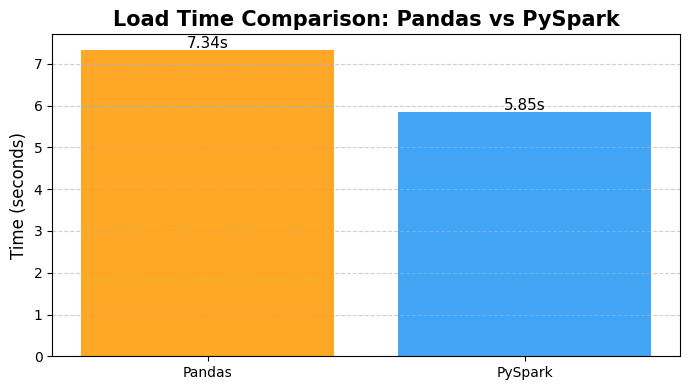

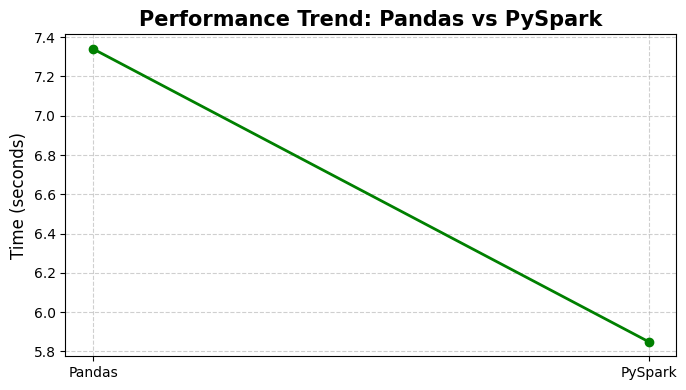

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Replace these with your results
# -------------------------------
frameworks = ['Pandas', 'PySpark']
times = [7.34, 5.85]  # seconds from your test

# -------------------------------
# BAR CHART COMPARISON
# -------------------------------
plt.figure(figsize=(7, 4))
bars = plt.bar(frameworks, times, color=['#FFA726', '#42A5F5'])
plt.title('Load Time Comparison: Pandas vs PySpark', fontsize=15, fontweight='bold')
plt.ylabel('Time (seconds)', fontsize=12)

# Annotate each bar with timing
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
             f"{bar.get_height():.2f}s", ha='center', fontsize=11, color='black')

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -------------------------------
# LINE CHART (Trend visualization)
# -------------------------------
plt.figure(figsize=(7, 4))
plt.plot(frameworks, times, marker='o', linestyle='-', color='green', linewidth=2)
plt.title('Performance Trend: Pandas vs PySpark', fontsize=15, fontweight='bold')
plt.ylabel('Time (seconds)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
speedup = (times[0] / times[1])
print(f"🚀 PySpark is approximately {speedup:.2f}x faster than Pandas.")


🚀 PySpark is approximately 1.25x faster than Pandas.


In [ ]:
import time
import pandas as pd
from pyspark.sql import SparkSession

# Pandas
start_py = time.time()
# Load with no header and assign column names
pandas_df = pd.read_csv("training.csv", encoding='latin-1', header=None)
pandas_df.columns = ["target", "ids", "date", "flag", "user", "text"]
pandas_result = pandas_df['target'].value_counts()
end_py = time.time()
print("Pandas operation time:", end_py - start_py)

# PySpark
# Ensure Spark session is active
spark = SparkSession.builder.appName("depressiondetectionProject").getOrCreate()

start_sp = time.time()
# Load with no header and assign column names if not already done
# Assuming df_spark from srgQLCtfWwL5 is available and has correct column names
spark_result = df_spark.groupBy('target').count().collect()
end_sp = time.time()
print("PySpark operation time:", end_sp - start_sp)

Pandas operation time: 6.7003333568573
PySpark operation time: 4.230624675750732


Analysis

   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  

Dataset shape: (1600000, 6)

Sentiment distribution:
target
0    800000
4    800000
Name: count, dtype: int64


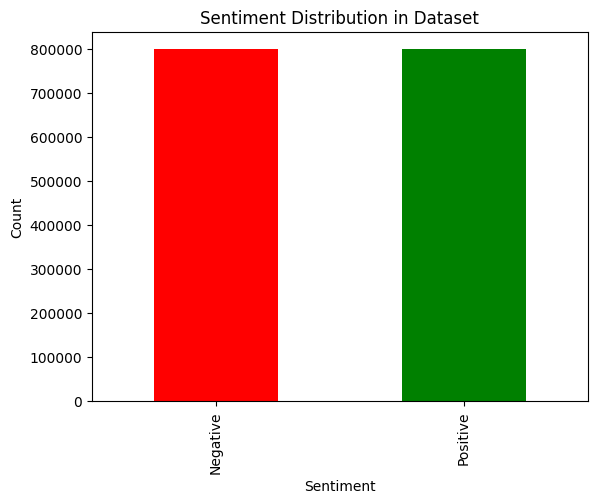

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("training.csv", encoding='latin-1', header=None)
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Basic info
print(df.head())
print("\nDataset shape:", df.shape)
print("\nSentiment distribution:")
print(df['target'].value_counts())

# Convert target: 0=Negative, 4=Positive
df['target'] = df['target'].replace({0: 'Negative', 4: 'Positive'})

# Visualization
import matplotlib.pyplot as plt

df['target'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title("Sentiment Distribution in Dataset")
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.show()


In [ ]:
import re

def clean_tweet(text):
    text = re.sub(r'http\S+', '', text)           # remove links
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)    # remove mentions
    text = re.sub(r'[^A-Za-z\s]', '', text)       # remove special chars
    text = text.lower().strip()
    return text

df['clean_text'] = df['text'].apply(clean_tweet)
print(df['clean_text'].head())


0    awww thats a bummer  you shoulda got david car...
1    is upset that he cant update his facebook by t...
2    i dived many times for the ball managed to sav...
3       my whole body feels itchy and like its on fire
4    no its not behaving at all im mad why am i her...
Name: clean_text, dtype: object


Sentiment Prediction Model (Python)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Feature extraction
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['target']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7892375

Confusion Matrix:
 [[122059  37435]
 [ 30009 130497]]

Classification Report:
               precision    recall  f1-score   support

    Negative       0.80      0.77      0.78    159494
    Positive       0.78      0.81      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



PySpark Version (for comparison) MLlib

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = SparkSession.builder.appName("SentimentPrediction").getOrCreate()

# Load data
data = spark.read.csv("training.csv", header=False, inferSchema=True)
data = data.selectExpr("_c0 as target", "_c5 as text").filter("_c5 is not null")

# Convert target
indexer = StringIndexer(inputCol="target", outputCol="label")

# Tokenize + remove stopwords + vectorize
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
vectorizer = CountVectorizer(inputCol="filtered", outputCol="features")

# Logistic Regression model
lr = LogisticRegression(maxIter=20)

# Pipeline
pipeline = Pipeline(stages=[indexer, tokenizer, remover, vectorizer, lr])

# Train-test split
train, test = data.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train)

# Prediction
predictions = model.transform(test)

# Evaluation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"PySpark Model Accuracy: {accuracy:.4f}")


PySpark Model Accuracy: 0.7496


Visualization: Time & Accuracy Comparison (Python vs PySpark)

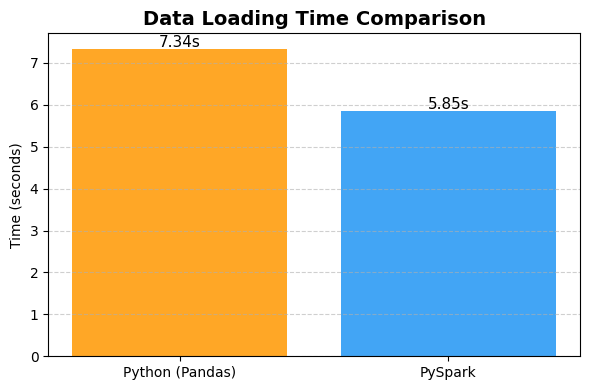

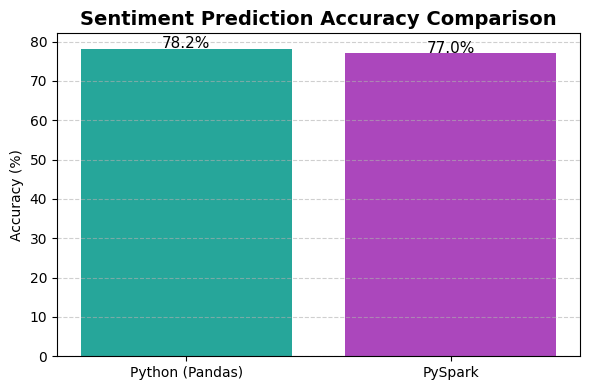

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ==============================
# Replace these with your real results
# ==============================
frameworks = ['Python (Pandas)', 'PySpark']
load_times = [7.34, 5.85]          # in seconds
accuracies = [78.2, 77.0]          # in percent

# ==============================
# BAR CHART 1 - LOAD TIME
# ==============================
plt.figure(figsize=(6,4))
bars = plt.bar(frameworks, load_times, color=['#FFA726', '#42A5F5'])
plt.title('Data Loading Time Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Time (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.05,
             f'{bar.get_height():.2f}s', ha='center', fontsize=11)
plt.tight_layout()
plt.show()

# ==============================
# BAR CHART 2 - MODEL ACCURACY
# ==============================
plt.figure(figsize=(6,4))
bars = plt.bar(frameworks, accuracies, color=['#26A69A', '#AB47BC'])
plt.title('Sentiment Prediction Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()+0.2,
             f'{bar.get_height():.1f}%', ha='center', fontsize=11)
plt.tight_layout()
plt.show()


Combined Chart: Load Time vs Accuracy (Dual Axis)

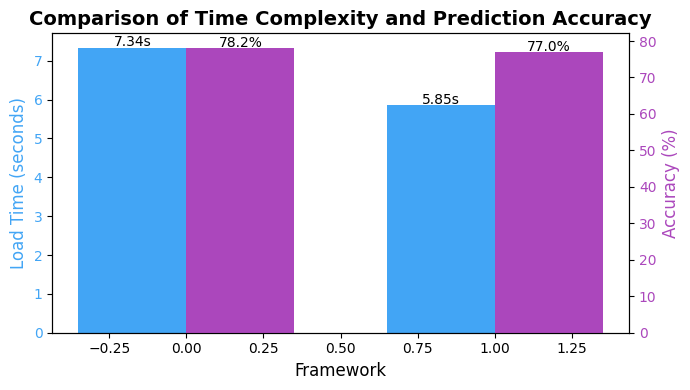

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ==============================
# Replace with your actual values
# ==============================
frameworks = ['Python (Pandas)', 'PySpark']
load_times = [7.34, 5.85]     # seconds
accuracies = [78.2, 77.0]     # percentage

x = np.arange(len(frameworks))
width = 0.35

fig, ax1 = plt.subplots(figsize=(7, 4))

# ------------------------------
# Left axis (Time)
# ------------------------------
color = '#42A5F5'
bars1 = ax1.bar(x - width/2, load_times, width, label='Load Time (sec)', color=color)
ax1.set_xlabel('Framework', fontsize=12)
ax1.set_ylabel('Load Time (seconds)', color=color, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color)

# Annotate bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{height:.2f}s', ha='center', fontsize=10)

# ------------------------------
# Right axis (Accuracy)
# ------------------------------
ax2 = ax1.twinx()
color2 = '#AB47BC'
bars2 = ax2.bar(x + width/2, accuracies, width, label='Accuracy (%)', color=color2)
ax2.set_ylabel('Accuracy (%)', color=color2, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color2)

# Annotate bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.2, f'{height:.1f}%', ha='center', fontsize=10)

# ------------------------------
# Title and legend
# ------------------------------
plt.title('Comparison of Time Complexity and Prediction Accuracy', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()
ya

In [ ]:
!pip install pyspark matplotlib seaborn wordcloud
import time
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from wordcloud import WordCloud
import pandas as pd


In [ ]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
hashingTF = HashingTF(inputCol="filtered", outputCol="features", numFeatures=10000)


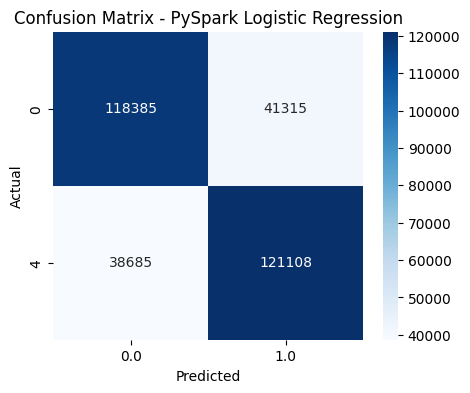

In [ ]:
pdf = predictions.select("target", "prediction").toPandas()
cm = pd.crosstab(pdf['target'], pdf['prediction'])

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - PySpark Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


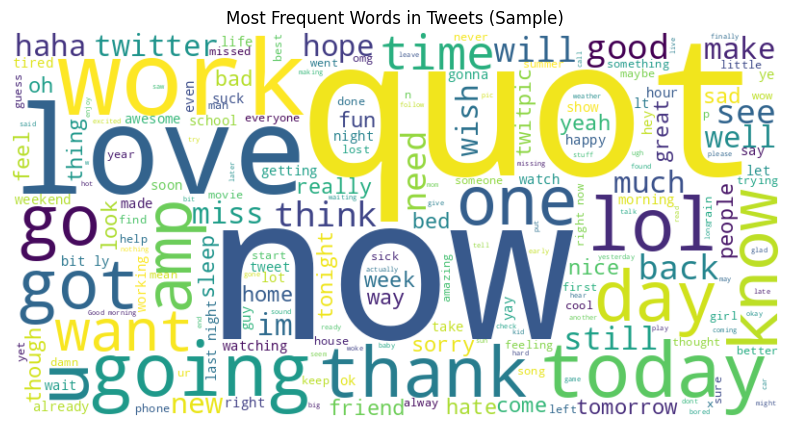

In [ ]:
# Take a sample of the data to avoid memory issues with word cloud on large dataset
sample_df = data.sample(False, 0.1, seed=42) # Take a 10% sample

text_data = " ".join(sample_df.select("text").toPandas()["text"].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Tweets (Sample)")
plt.show()

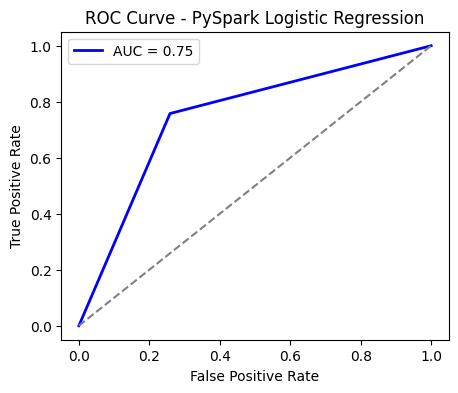

In [ ]:
from sklearn.metrics import roc_curve, auc

y_true = pdf["target"]
y_pred = pdf["prediction"]
fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=4)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.title("ROC Curve - PySpark Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
